# Topic Modeling

* By Wai Ping Jerry KWOK
* Created on 2023-11-30

**Objective:**

To find a use case for topic modeling, then source the data and develop code to address the use case; to provide a written explanation of what is done along with an executive summary and conclusion.

**Problem Statement:**

You are to develop your own use case for topic modeling. It should concern text data that you are interested in and be realistic for a data scientist or machine learning developer.

**Data:**

Obtained from BBC News Classification | Kaggle https://www.kaggle.com/competitions/learn-ai-bbc

**Steps to Completion:**

Develop one or more Jupyter notebook(s) containing code and written content in markdown. The notebook(s) should contain the sections listed below, indicated with clear headings. Where coding is done, provide comments to explain how it works. Develop this project as if you are creating it for important stakeholders connected to the use case.

# **Executive Summary:**

Our project is to apply topic modelling to news classification, which has many applications, such as personalized news feeds, targeted advertising, and news trend analysis. The BBC news dataset has 1490 records across 5 categories: business, entertainment, politics, sport, and tech. The preprocessing includes removing stop words, non-English words, and words less than 5 characters, removing punctuation, standardizing case, lemmatizing, and tokenizing. We develop 6 LDA models and 6 NMF models and experiment with various hyperparameters, such as the number of features, maximum document frequency, minimum document frequency, etc. Given that our dataset is relatively small, we tend to choose smaller numbers for the above hyperparameters.

The best LDA model is model 4, as it achieves a low perplexity and each bubble shown in the pyLDAvis has a reasonable size and distinct circle. This model best addresses our use case as it accurately classifies news articles into 5 categories, and the topic words found in the word-topic table align with the 5 topics in the original dataset. The word-topic tables show that the abstract topics for the business category include words like 'software' and 'Microsoft', which may suggest that giant software companies like Microsoft are closely related to business news. (200)




### Environment Preparation

In [2]:
# import libraries
import langdetect  # language detection
import matplotlib.pyplot as plt  # plotting
import numpy as np  # arrays and matrices
import nltk  # natural language processing
import pandas as pd  # dataframes
import regex as re # regular expressions
from time import time # track time
from prettytable import PrettyTable # table formatting

import pyLDAvis  # plotting

# import pyLDAvis.sklearn  # plotting
# import pyLDAvis.lda_model  # plotting

import sklearn  # machine learning
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
from sklearn.manifold import TSNE
from sklearn.metrics import mean_squared_error

from wordcloud import WordCloud

import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [4]:
# installing specific word dictionarys
# used for stopword removal and lemmatization
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jerry\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\jerry\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# **Preprocessing:**

Develop code to prepare the data for LDA and NMF topic modeling as we have done in class. This includes cleaning, standardizing case, lemmatizing, removing stop words, and tokenizing.

In [6]:
url_bbc ="https://raw.githubusercontent.com/PKpacheco/final_uml/main/BBC%20News%20Train.csv"

In [7]:
# load the data
df = pd.read_csv(url_bbc)
df.head()

,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business


In [8]:
# define a quick look function for data frame
def dataframe_quick_look(df, nrows):
    print("SHAPE:\n{shape}\n".format(shape=df.shape))
    print("COLUMN NAMES:\n{names}\n".format(names=df.columns))
    print("HEAD:\n{head}\n".format(head=df.head(nrows)))

In [9]:
# test the function
dataframe_quick_look(df, nrows=2)

SHAPE:
(1490, 3)

COLUMN NAMES:
Index(['ArticleId', 'Text', 'Category'], dtype='object')

HEAD:
   ArticleId                                               Text  Category
0       1833  worldcom ex-boss launches defence lawyers defe...  business
1        154  german business confidence slides german busin...  business



In [10]:
# data set came with prespecified topics
# print the topics out with counts
df["Category"].value_counts()

sport            346
business         336
politics         274
entertainment    273
tech             261
Name: Category, dtype: int64

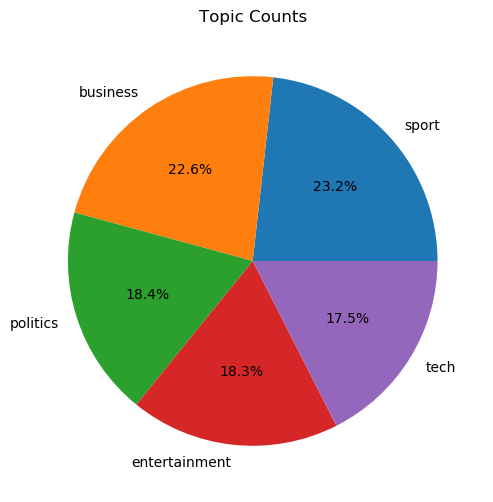

In [11]:
# visualize the topic counts by percentage in a pie chart
plt.figure(figsize=(6, 6))
plt.pie(df["Category"].value_counts(), labels=df["Category"].value_counts().index, autopct='%1.1f%%')
plt.title("Topic Counts")
plt.show()

**Observation**

We can see that toplics such as politcs, entertainment, and tech have roughtly 4% less representations then business and sport. It is comparatively balanced dataset.

In [12]:
# view final data that will be carried forward
raw = df['Text'].tolist()
print("NEWS:\n{lines}\n".format(lines=raw[:2]))
print("LENGTH:\n{length}\n".format(length=len(raw)))

NEWS:
['worldcom ex-boss launches defence lawyers defending former worldcom chief bernie ebbers against a battery of fraud charges have called a company whistleblower as their first witness.  cynthia cooper  worldcom s ex-head of internal accounting  alerted directors to irregular accounting practices at the us telecoms giant in 2002. her warnings led to the collapse of the firm following the discovery of an $11bn (£5.7bn) accounting fraud. mr ebbers has pleaded not guilty to charges of fraud and conspiracy.  prosecution lawyers have argued that mr ebbers orchestrated a series of accounting tricks at worldcom  ordering employees to hide expenses and inflate revenues to meet wall street earnings estimates. but ms cooper  who now runs her own consulting business  told a jury in new york on wednesday that external auditors arthur andersen had approved worldcom s accounting in early 2001 and 2002. she said andersen had given a  green light  to the procedures and practices used by worldcom.

In [13]:
# define function for checking language of test
# filter to english only
def do_language_identifying(txt):
    try:
       the_language = langdetect.detect(txt)
    except:
       the_language = 'none'
    return the_language

In [14]:
# define function to perform lemmatization
def do_lemmatizing(wrd):
    out = nltk.corpus.wordnet.morphy(wrd)
    return (wrd if out is None else out)

In [15]:
# more stop words to remove
stop_words_news = pd.read_csv('https://raw.githubusercontent.com/vikasing/news-stopwords/master/sw1k.csv')
stop_words_news_list = stop_words_news['term'].to_list()
stop_words_news_list

['the',
 'to',
 'and',
 'of',
 'a',
 'in',
 'on',
 'for',
 's',
 'is',
 'with',
 'that',
 'at',
 'by',
 'it',
 'as',
 'from',
 'was',
 'be',
 'has',
 'an',
 'this',
 'have',
 'are',
 'not',
 'said',
 'but',
 'will',
 'he',
 'who',
 'been',
 'after',
 'their',
 'one',
 'which',
 'they',
 'his',
 'up',
 'also',
 'more',
 'all',
 'about',
 'or',
 'we',
 'out',
 'had',
 'year',
 'were',
 'new',
 'when',
 't',
 'there',
 'two',
 'you',
 'over',
 'its',
 'can',
 'would',
 'first',
 'time',
 'last',
 'if',
 'other',
 'than',
 'i',
 'no',
 'into',
 'so',
 'some',
 'people',
 'what',
 'while',
 'just',
 'could',
 'now',
 'years',
 'like',
 'get',
 'only',
 'our',
 'them',
 'before',
 'most',
 'may',
 'being',
 'do',
 'three',
 'make',
 'any',
 'day',
 'made',
 'how',
 'back',
 'us',
 'during',
 'where',
 '1',
 'against',
 'even',
 'because',
 'your',
 'since',
 'many',
 'off',
 'she',
 'him',
 'her',
 'take',
 'through',
 'well',
 'world',
 'told',
 'down',
 'then',
 'including',
 'state',
 'wa

In [16]:
# define function to cleaning text data

def do_text_cleaning(txt):
    # identify language of text
    # return null if language not english
    lg = do_language_identifying(txt)
    if lg != 'en':
        return None

    # split the string on whitespace
    out = txt.split(' ')

    # identify screen names
    # replace with SCREENNAME
    out = ['SCREENNAME' if i.startswith('@') else i for i in out]

    # identify urls
    # replace with URL
    out = [
        'URL' if bool(re.search('http[s]?://', i))
        else i for i in out
    ]

    # remove all punctuation
    out = [re.sub('[^\\w\\s]|\n', '', i) for i in out]

    # make all non-keywords lowercase
    keys = ['SCREENNAME', 'URL']
    out = [i.lower() if i not in keys else i for i in out]

    # remove keywords
    out = [i for i in out if i not in keys]

    # remove stopwords
    stop_words = nltk.corpus.stopwords.words('english')
    list_stop_words = stop_words + stop_words_news_list
    list_stop_words = [re.sub('[^\\w\\s]', '', i) for i in list_stop_words]
    out = [i for i in out if i not in list_stop_words]

    # lemmatizing
    out = [do_lemmatizing(i) for i in out]

    # keep words 4 or more characters long
    out = [i for i in out if len(i) >= 5]

    return out

In [17]:
# apply cleaning function to every tweet
tick = time()
clean = list(map(do_text_cleaning, raw))
print(time()-tick)

48.389920473098755


In [18]:
# remove none types
clean = list(filter(None.__ne__, clean))
print("NEWS:\n{lines}\n".format(lines=clean[:2]))
print("LENGTH:\n{length}\n".format(length=len(clean)))

NEWS:
[['worldcom', 'exboss', 'launch', 'defence', 'lawyer', 'defend', 'worldcom', 'bernie', 'ebbers', 'battery', 'fraud', 'whistleblower', 'witness', 'cynthia', 'cooper', 'worldcom', 'exhead', 'internal', 'accounting', 'alert', 'director', 'irregular', 'accounting', 'practice', 'telecom', 'giant', 'warning', 'collapse', 'discovery', 'accounting', 'fraud', 'ebbers', 'plead', 'guilty', 'fraud', 'conspiracy', 'prosecution', 'lawyer', 'argue', 'ebbers', 'orchestrate', 'accounting', 'trick', 'worldcom', 'ordering', 'employee', 'expense', 'inflate', 'revenue', 'earnings', 'estimate', 'cooper', 'consult', 'external', 'auditor', 'arthur', 'andersen', 'approve', 'worldcom', 'accounting', 'andersen', 'green', 'procedure', 'practice', 'worldcom', 'ebber', 'lawyer', 'unaware', 'fraud', 'arguing', 'auditor', 'alert', 'cooper', 'shareholder', 'meeting', 'ebbers', 'technical', 'finance', 'brief', 'answer', 'prosecution', 'witness', 'worldcom', 'scott', 'sullivan', 'ebbers', 'order', 'accounting', 'a

**Discussion**

The final list contains 1490 entries.

In [19]:
# turn tokens back into strings
# concatenate using whitespaces

clean_sentences = [" ".join(i) for i in clean]

In [20]:
print(clean_sentences[0:4])

['worldcom exboss launch defence lawyer defend worldcom bernie ebbers battery fraud whistleblower witness cynthia cooper worldcom exhead internal accounting alert director irregular accounting practice telecom giant warning collapse discovery accounting fraud ebbers plead guilty fraud conspiracy prosecution lawyer argue ebbers orchestrate accounting trick worldcom ordering employee expense inflate revenue earnings estimate cooper consult external auditor arthur andersen approve worldcom accounting andersen green procedure practice worldcom ebber lawyer unaware fraud arguing auditor alert cooper shareholder meeting ebbers technical finance brief answer prosecution witness worldcom scott sullivan ebbers order accounting adjustment telling cooper sullivan mention uncomfortable worldcom accounting audit ebbers sentence convict worldcom emerge bankruptcy protection agree buyout verizon communications value 675bn', 'german confidence slide german confidence knocking speedy recovery munichbas

# **Models:**

Develop code to first vectorize your data, and then to train at least six LDA and NMF topic models on these vectors. Make clear section headings for each type of model, record each set of hyperparameters (for both vectorization and the topic models) you try, and find the perplexity, word-topic table and document-topic table for each; present this information neatly and use it to choose your best LDA and NMF models.

In [21]:
# import the appropriate packages depending on the environment
import pyLDAvis.sklearn  # plotting
# import pyLDAvis.lda_model  # plotting

## LDA Model

In [22]:
# define function to calculate perplexity based on number of topics
def perplexity_by_ntopic(data, ntopics):
    output_dict = {
        "Number Of Topics": [],
        "Perplexity Score": []
    }

    for t in ntopics:
        lda = LatentDirichletAllocation(
            n_components=t,
            learning_method="online",
            random_state=0
        )
        lda.fit(data)

        output_dict["Number Of Topics"].append(t)
        output_dict["Perplexity Score"].append(lda.perplexity(data))

    output_df = pd.DataFrame(output_dict)

    index_min_perplexity = output_df["Perplexity Score"].idxmin()
    output_num_topics = output_df.loc[
        index_min_perplexity,  # index
        "Number Of Topics"  # column
    ]

    return (output_df, output_num_topics)

In [23]:
# define a function to do bag of words conversion
def do_bag_of_words_conversion(clean_sentences, max_df, min_df, max_features):
    # convert to bag of words
    vectorizer = CountVectorizer(
        analyzer="word",
        max_df=max_df,    # ignore words that appear in max_df% of documents
        min_df=min_df,    # ignore words that appear in less than min_df documents
        max_features=max_features
    )
    bow = vectorizer.fit_transform(clean_sentences)

    # use appropriate code depending on the environment
    feature_names_vec = vectorizer.get_feature_names()
    # feature_names_vec = vectorizer.get_feature_names_out()

    return vectorizer, bow, feature_names_vec

In [24]:
# define a function to do bag of words conversion and obtain the perplexity
def get_perplexity_and_plot(bow, max_ntopics):

    # execute function on vector of numbers of topics
    perplexity, optimal_num_topics = perplexity_by_ntopic(
        bow,
        ntopics=list(range(1, max_ntopics+1))
    )

    print(perplexity)
    print('\n')
    print(f'Optimal Number of Topics: {optimal_num_topics}')

    # plot perplexity by number of topics
    # plt.figure(figsize=(6, 3))
    plt.figure(figsize=(3, 2))
    plt.plot(perplexity["Number Of Topics"], perplexity["Perplexity Score"])
    plt.xlabel("Number Of Topics")
    plt.ylabel("Perplexity Score")
    plt.title("Perplexity Score By Number Of Topics")
    plt.show()

    return perplexity, optimal_num_topics

In [25]:
# define a function to do LDA
def do_lda(bow, num_topics):
    # fit and transform the data
    lda = LatentDirichletAllocation(
        n_components=num_topics,  # optimal_num_topics,
        learning_method="online",
        random_state=0
    )
    lda.fit(bow)

    lda_transform = lda.transform(bow)

    # obtain the components
    lda_components = lda.components_

    return lda, lda_transform, lda_components

In [26]:
# define function to format raw output into nice tables

def get_topics(mod, vec, names, docs, ndocs, nwords):
    # word to topic matrix
    W = mod.components_
    W_norm = W / W.sum(axis=1)[:, np.newaxis]
    # topic to document matrix
    H = mod.transform(vec)

    W_dict = {}
    H_dict = {}

    for tpc_idx, tpc_val in enumerate(W_norm):
        topic = "Topic{}".format(tpc_idx)

        # formatting w
        W_indices = tpc_val.argsort()[::-1][:nwords]
        W_names_values = [
            (round(tpc_val[j], 4), names[j])
            for j in W_indices
        ]
        W_dict[topic] = W_names_values

        # formatting h
        H_indices = H[:, tpc_idx].argsort()[::-1][:ndocs]
        H_names_values = [
            (round(H[:, tpc_idx][j], 4), docs[j])
            for j in H_indices
        ]
        H_dict[topic] = H_names_values

    W_df = pd.DataFrame(
        W_dict,
        index=["Word" + str(i) for i in range(nwords)]
    )
    H_df = pd.DataFrame(
        H_dict,
        index=["Doc" + str(i) for i in range(ndocs)]
    )

    return (W_df, H_df)

In [27]:
# define functiont to fit and plot t-SNE model

def plot_tsne(data, threshold):
    # filter data according to threshold
    index_meet_threshold = np.amax(data, axis=1) >= threshold
    lda_transform_filt = data[index_meet_threshold]

    # fit tsne model
    # x-d -> 2-d, x = number of topics
    tsne = TSNE(
        n_components=2,
        verbose=0,
        random_state=0,
        angle=0.5,
        init='pca'
    )
    tsne_fit = tsne.fit_transform(lda_transform_filt)

    # most probable topic for each headline
    most_prob_topic = []
    for i in range(tsne_fit.shape[0]):
        most_prob_topic.append(lda_transform_filt[i].argmax())

    # print("LENGTH:\n{}\n".format(len(most_prob_topic)))

    unique, counts = np.unique(
        np.array(most_prob_topic),
        return_counts=True
    )

    # print("COUNTS:\n{}\n".format(np.asarray((unique, counts)).T))

    # make plot
    color_list = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'orange', 'purple']

    for i in list(set(most_prob_topic)):
        indices = [idx for idx, val in enumerate(most_prob_topic) if val == i]
        plt.scatter(
            x=tsne_fit[indices, 0],
            y=tsne_fit[indices, 1],
            s=1,
            c=color_list[i],
            label='Topic' + str(i),
            alpha=0.5
        )

    plt.xlabel('x-tsne')
    plt.ylabel('y-tsne')
    plt.legend(markerscale=10, bbox_to_anchor=(1.04, 1), loc="upper left")

In [28]:
# define global variables for visualization of LDA results
number_words = 10
number_docs = 10

In [29]:
# setup a dictionary to setup parameters and store the results
lda_dict = {}

### LDA Model 1 {'number_features': 1500, 'vec_max_df': 0.05, 'vec_min_df': 20}

In [30]:
mod_name = 'lda1'

# add parameters to dictionary
lda_dict[mod_name] = {
    'number_features': 1500,
    'vec_max_df': 0.05,
    'vec_min_df': 20
}

   Number Of Topics  Perplexity Score
0                 1       1044.984562
1                 2        912.966717
2                 3        856.094455
3                 4        852.896590
4                 5        813.227926
5                 6        780.587092
6                 7        755.739861
7                 8        782.380783


Optimal Number of Topics: 7


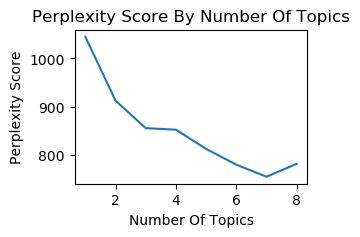

In [31]:
# perform bag of words conversion
vectorizer1, clean_vec1, feature_names_vec1 = do_bag_of_words_conversion(
    clean_sentences,
    lda_dict[mod_name]['vec_max_df'],
    lda_dict[mod_name]['vec_min_df'],
    lda_dict[mod_name]['number_features']
    )

# get perplexity and plot
perplexity1, optimal_num_topics1 = get_perplexity_and_plot(clean_vec1, 8)

In [32]:
# run the do_lda function
lda1, lda_transform1, lda_components1 = do_lda(
    clean_vec1,
    optimal_num_topics1
    )

# get nice tables
W_df1, H_df1 = get_topics(
    mod=lda1,
    vec=clean_vec1,
    names=feature_names_vec1,
    docs=raw,
    ndocs=number_docs,
    nwords=number_words
    )

In [33]:
# word-topic table: top 10 words for each topic
W_df1

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6
Word0,"(0.0217, oscar)","(0.0442, search)","(0.0156, chelsea)","(0.0101, airline)","(0.0117, fraud)","(0.0198, microsoft)","(0.0171, rates)"
Word1,"(0.02, actress)","(0.0344, chart)","(0.0113, rugby)","(0.0093, kennedy)","(0.0115, shareholder)","(0.0186, gadget)","(0.0152, japan)"
Word2,"(0.0194, prize)","(0.0287, album)","(0.0108, williams)","(0.0091, trust)","(0.0113, criminal)","(0.0164, virus)","(0.0151, phone)"
Word3,"(0.0164, singer)","(0.0236, festival)","(0.0104, arsenal)","(0.0089, reform)","(0.0097, asylum)","(0.0156, machine)","(0.0145, profits)"
Word4,"(0.0162, production)","(0.0193, studio)","(0.0097, olympic)","(0.0087, voter)","(0.0088, bankruptcy)","(0.0128, apple)","(0.0142, deficit)"
Word5,"(0.0154, nomination)","(0.0171, google)","(0.0096, championship)","(0.0075, commons)","(0.0087, lawyer)","(0.0128, broadband)","(0.0132, export)"
Word6,"(0.0149, producer)","(0.0153, christmas)","(0.0094, irish)","(0.0072, education)","(0.0079, parliament)","(0.0124, download)","(0.0117, camera)"
Word7,"(0.014, ceremony)","(0.0153, record)","(0.0093, manchester)","(0.0072, pension)","(0.0079, russian)","(0.0119, network)","(0.0109, market)"
Word8,"(0.0137, audience)","(0.0151, speed)","(0.0092, liverpool)","(0.0071, debate)","(0.0078, suspect)","(0.0113, devices)","(0.0108, forecast)"
Word9,"(0.013, category)","(0.0124, broadband)","(0.0092, davis)","(0.0069, pledge)","(0.0076, document)","(0.0098, gaming)","(0.0104, germany)"


In [34]:
# document-topic table: top 10 documents for each topic
H_df1

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6
Doc0,"(0.9847, bafta to hand out movie honours movie...","(0.9852, downloads enter us singles chart digi...","(0.9911, wales win in rome wales secured their...","(0.99, goldsmith denies war advice claim the a...","(0.9894, dozens held over id fraud site twenty...","(0.9941, apple laptop is greatest gadget the...","(0.989, camera phones are must-haves four ti..."
Doc1,"(0.9813, levy tipped for whitbread prize novel...","(0.9852, downloads enter us singles chart digi...","(0.9905, nadal puts spain 2-0 up result: nadal...","(0.9888, goldsmith: i was not leant on the a...","(0.9864, enron bosses in $168m payout eighteen...","(0.9928, apple laptop is greatest gadget the...","(0.989, camera phones are must-haves four ti..."
Doc2,"(0.9813, bbc leads interactive bafta wins the ...","(0.974, prodigy join v festival line-up essex ...","(0.9903, britain boosted by holmes double athl...","(0.9838, debate needed on donations cap a cap...","(0.9841, worldcom director admits lying the fo...","(0.9927, rivals of the £400 apple... the mac m...","(0.9881, uk interest rates held at 4.75% the b..."
Doc3,"(0.9801, stars gear up for bafta ceremony film...","(0.9704, fockers fuel festive film chart comed...","(0.9888, paris promise raises welsh hopes has ...","(0.9838, debate needed on donations cap a cap...","(0.9835, worldcom ex-boss launches defence law...","(0.9901, doors open at biggest gadget fair tho...","(0.9838, german business confidence slides ger..."
Doc4,"(0.9761, oscar host rock to keep it clean osca...","(0.9643, brits return keane to number one brit...","(0.9868, chelsea hold arsenal a gripping game ...","(0.9835, blair rejects iraq advice calls tony ...","(0.9832, ebbers denies worldcom fraud former w...","(0.9901, doors open at biggest gadget fair tho...","(0.9832, bank opts to leave rates on hold the ..."
Doc5,"(0.974, south bank awards honour hit soap coro...","(0.9627, streets have album of the year the ...","(0.9854, ireland surge past scots ireland main...","(0.9805, talks aim to avert pension strike tal...","(0.98, borders rail link campaign rally campai...","(0.9881, gates opens biggest gadget fair bill ...","(0.9817, optimism remains over uk housing the ..."
Doc6,"(0.9723, queen recruit singer for new tour the...","(0.9522, hillbillies singer scoggins dies coun...","(0.9854, campbell rescues arsenal sol campbell...","(0.9805, talks aim to avert pension strike tal...","(0.9796, worldcom bosses $54m payout ten form...","(0.9862, microsoft makes anti-piracy move micr...","(0.9805, brewers profits lose their fizz hein..."
Doc7,"(0.9723, queen recruit singer for new tour the...","(0.9495, pop band busted to take a break cha...","(0.9847, o driscoll saves irish blushes two mo...","(0.98, stalemate in pension strike talks talks...","(0.9774, id theft surge hits us consumers almo...","(0.9841, virus poses as christmas e-mail secur...","(0.98, trade gap narrows as exports rise the u..."
Doc8,"(0.9714, us critics laud comedy sideways road ...","(0.9495, pop band busted to take a break cha...","(0.9832, jones happy with henson heroics wales...","(0.978, civil servants in strike ballot the uk...","(0.9643, insurance bosses plead guilty another...","(0.9841, virus poses as christmas e-mail secur...","(0.9791, golden economic period to end ten ye..."
Doc9,"(0.9701, levy takes whitbread novel prize oran...","(0.9463, fockers keeps us box office lead film...","(0.9832, white prepared for battle tough-scrum...","(0.9747, brown outlines third term vision gord...","(0.961, parmalat bank barred from suing bank o...","(0.9838, microsoft debuts security tools micro...","(0.9785, uk risks breaking golden rule the u..."


In [35]:
# get perplexity for optimal number of topics
perplexity1 = perplexity1.loc[perplexity1['Number Of Topics'] == optimal_num_topics1, 'Perplexity Score'].values[0]
lda_dict[mod_name]['perplexity'] = perplexity1

# put the results into a dictionary
lda_dict[mod_name]['optimal_num_topics'] = optimal_num_topics1
lda_dict[mod_name]['W_df'] = W_df1
lda_dict[mod_name]['H_df'] = H_df1

### LDA Model 2 {'number_features': 1750, 'vec_max_df': 0.05, 'vec_min_df': 12}

In [36]:
mod_name = 'lda2'

# add parameters to dictionary
lda_dict[mod_name] = {
    'number_features': 1750,
    'vec_max_df': 0.05,
    'vec_min_df': 12
}

   Number Of Topics  Perplexity Score
0                 1       1567.072770
1                 2       1365.755911
2                 3       1199.100750
3                 4       1141.680584
4                 5       1178.806321
5                 6       1176.848048


Optimal Number of Topics: 4


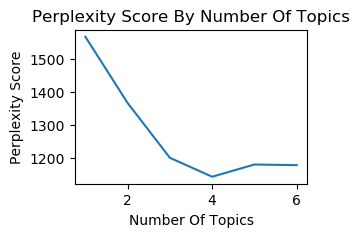

In [37]:
# perform bag of words conversion
vectorizer2, clean_vec2, feature_names_vec2 = do_bag_of_words_conversion(
    clean_sentences,
    lda_dict[mod_name]['vec_max_df'],
    lda_dict[mod_name]['vec_min_df'],
    lda_dict[mod_name]['number_features']
    )

# get perplexity and plot
perplexity2, optimal_num_topics2 = get_perplexity_and_plot(clean_vec2, 6)

In [38]:
# run the do_lda function
lda2, lda_transform2, lda_components2 = do_lda(
    clean_vec2,
    optimal_num_topics2
    )

# get nice tables
W_df2, H_df2 = get_topics(
    mod=lda2,
    vec=clean_vec2,
    names=feature_names_vec2,
    docs=raw,
    ndocs=number_docs,
    nwords=number_words
    )

In [39]:
# word topic table: top 10 words for each topic
W_df2

,Topic0,Topic1,Topic2,Topic3
Word0,"(0.0047, rates)","(0.0109, chelsea)","(0.0134, microsoft)","(0.011, chart)"
Word1,"(0.0044, parliament)","(0.0079, rugby)","(0.0127, search)","(0.0105, oscar)"
Word2,"(0.0039, stock)","(0.0075, williams)","(0.0118, broadband)","(0.0103, album)"
Word3,"(0.0037, deficit)","(0.0073, arsenal)","(0.0118, gadget)","(0.0089, actress)"
Word4,"(0.0037, exchange)","(0.0069, manchester)","(0.0108, virus)","(0.0086, singer)"
Word5,"(0.0037, kennedy)","(0.0068, olympic)","(0.0096, machine)","(0.0083, yukos)"
Word6,"(0.0036, reform)","(0.0068, championship)","(0.0082, apple)","(0.0082, festival)"
Word7,"(0.0035, export)","(0.0065, irish)","(0.008, network)","(0.008, prize)"
Word8,"(0.0034, debate)","(0.0065, liverpool)","(0.0078, phone)","(0.0078, producer)"
Word9,"(0.0034, trust)","(0.0063, jones)","(0.0074, airline)","(0.0072, audience)"


In [40]:
# document topic table: top 10 documents for each topic
H_df2

,Topic0,Topic1,Topic2,Topic3
Doc0,"(0.9975, minimum wage increased to £5.05 the m...","(0.996, all black magic: new zealand rugby pla...","(0.995, apple laptop is greatest gadget the ...","(0.9961, critics back aviator for oscars marti..."
Doc1,"(0.9937, booming markets shed few tears the ma...","(0.9957, nadal puts spain 2-0 up result: nadal...","(0.9933, toxic web links help virus spread vir...","(0.9933, the producers scoops stage awards the..."
Doc2,"(0.9935, giant waves damage s asia economy gov...","(0.9936, britain boosted by holmes double athl...","(0.9926, concerns over windows atms cash machi...","(0.993, aviator wins top globes accolades the ..."
Doc3,"(0.9919, anti-terror plan faces first test pla...","(0.9931, what now for kelly holmes last april...","(0.9913, apple mac mini gets warm welcome the ...","(0.9923, eastwood s baby scoops top oscars cli..."
Doc4,"(0.9915, asia quake increases poverty risk nea...","(0.9931, wales win in rome wales secured their...","(0.9909, have hackers recruited your pc more ...","(0.9916, british stars denied major oscars bri..."
Doc5,"(0.9912, howard unveils tory asylum plans tory...","(0.9926, henman to face saulnier test british ...","(0.9902, security scares spark browser fix mic...","(0.9908, stars shine on bafta red carpet holly..."
Doc6,"(0.9912, india unveils anti-poverty budget ind...","(0.9923, a year to remember for irish there us...","(0.9889, google s toolbar sparks concern searc...","(0.9905, bafta to hand out movie honours movie..."
Doc7,"(0.991, muslims discuss election concerns issu...","(0.9922, holmes back on form in birmingham dou...","(0.9887, rivals of the £400 apple... the mac m...","(0.9902, vera drake s bafta triumph hope at th..."
Doc8,"(0.9908, goldsmith: i was not leant on the a...","(0.992, chelsea hold arsenal a gripping game b...","(0.9884, virus poses as christmas e-mail secur...","(0.9901, hollywood ready for oscars night holl..."
Doc9,"(0.9907, brown targets oaps and homebuyers gor...","(0.992, ireland 17-12 south africa ronan o gar...","(0.9884, virus poses as christmas e-mail secur...","(0.99, grammys honour soul star charles the me..."


In [41]:
# get perplexity for optimal number of topics
perplexity2 = perplexity2.loc[perplexity2['Number Of Topics'] == optimal_num_topics2, 'Perplexity Score'].values[0]
lda_dict[mod_name]['perplexity'] = perplexity2

# put the results into a dictionary
lda_dict[mod_name]['optimal_num_topics'] = optimal_num_topics2
lda_dict[mod_name]['W_df'] = W_df2
lda_dict[mod_name]['H_df'] = H_df2

### LDA Model 3 {'number_features': 1500, 'vec_max_df': 0.02, 'vec_min_df': 15}

In [42]:
mod_name = 'lda3'

# add parameters to dictionary
lda_dict[mod_name] = {
    'number_features': 1500,
    'vec_max_df': 0.02,
    'vec_min_df': 15
}

   Number Of Topics  Perplexity Score
0                 1        942.924946
1                 2        859.591107
2                 3        854.003968
3                 4        878.386161
4                 5        879.469404


Optimal Number of Topics: 3


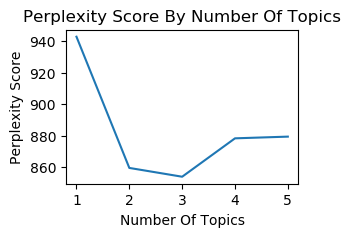

In [43]:
# perform bag of words conversion
vectorizer3, clean_vec3, feature_names_vec3 = do_bag_of_words_conversion(
    clean_sentences,
    lda_dict[mod_name]['vec_max_df'],
    lda_dict[mod_name]['vec_min_df'],
    lda_dict[mod_name]['number_features']
    )

# get perplexity and plot
perplexity3, optimal_num_topics3 = get_perplexity_and_plot(clean_vec3, 5)

In [44]:
# run the do_lda function
lda3, lda_transform3, lda_components3 = do_lda(
    clean_vec3,
    optimal_num_topics3
    )

# get nice tables
W_df3, H_df3 = get_topics(
    mod=lda3,
    vec=clean_vec3,
    names=feature_names_vec3,
    docs=raw,
    ndocs=number_docs,
    nwords=number_words
    )

In [45]:
# word topic table: top 10 words for each topic
W_df3

,Topic0,Topic1,Topic2
Word0,"(0.0138, yukos)","(0.0086, campbell)","(0.0067, clarke)"
Word1,"(0.0129, airline)","(0.007, ferguson)","(0.0061, poverty)"
Word2,"(0.0127, google)","(0.007, athens)","(0.0059, mourinho)"
Word3,"(0.0103, roddick)","(0.006, medal)","(0.0059, arrest)"
Word4,"(0.0093, asylum)","(0.006, dance)","(0.0059, poster)"
Word5,"(0.0087, handset)","(0.006, musician)","(0.0059, terror)"
Word6,"(0.0078, deutsche)","(0.0059, indoor)","(0.0057, blunkett)"
Word7,"(0.0075, engine)","(0.0056, athletics)","(0.0051, housing)"
Word8,"(0.0065, nintendo)","(0.0056, prince)","(0.005, index)"
Word9,"(0.0065, auction)","(0.0055, laptop)","(0.0048, mortgage)"


In [46]:
# document topic table: top 10 documents for each topic
H_df3

,Topic0,Topic1,Topic2
Doc0,"(0.9923, nadal puts spain 2-0 up result: nadal...","(0.9911, critics back aviator for oscars marti...","(0.9874, muslims discuss election concerns iss..."
Doc1,"(0.9851, yukos unit fetches $9bn at auction a ...","(0.9852, the producers scoops stage awards the...","(0.982, terror suspects face house arrest uk c..."
Doc2,"(0.9851, henman to face saulnier test british ...","(0.9846, britain boosted by holmes double athl...","(0.98, anti-terror plan faces first test plans..."
Doc3,"(0.9846, toxic web links help virus spread vir...","(0.9843, goldsmith denies war advice claim the...","(0.9798, opposition grows to house arrests the..."
Doc4,"(0.9826, rich pickings for hi-tech thieves vir...","(0.9833, irish finish with home game republic ...","(0.9793, intel unveils laser breakthrough inte..."
Doc5,"(0.9818, microsoft makes anti-piracy move micr...","(0.9818, a year to remember for irish there us...","(0.9783, blunkett unveils policing plans peopl..."
Doc6,"(0.9802, deutsche attacks yukos case german in...","(0.9817, eastwood s baby scoops top oscars cli...","(0.9779, text messages aid disaster recovery t..."
Doc7,"(0.9799, nintendo ds aims to touch gamers the ...","(0.9813, ireland 19-13 england ireland consign...","(0.9762, boateng to step down at election paul..."
Doc8,"(0.9794, warnings about junk mail deluge the a...","(0.981, aviator and vera take bafta glory holl...","(0.9758, anglers could face prosecution angl..."
Doc9,"(0.9794, yukos seeks court action on sale yuko...","(0.9807, vera drake leads uk oscar hopes mike ...","(0.9755, chancellor rallies labour voters gord..."


In [47]:
# get perplexity for optimal number of topics
perplexity3 = perplexity3.loc[perplexity3['Number Of Topics'] == optimal_num_topics3, 'Perplexity Score'].values[0]
lda_dict[mod_name]['perplexity'] = perplexity3

# put the results into a dictionary
lda_dict[mod_name]['optimal_num_topics'] = optimal_num_topics3
lda_dict[mod_name]['W_df'] = W_df3
lda_dict[mod_name]['H_df'] = H_df3

### LDA Model 4 {'number_features': 1250, 'vec_max_df': 0.1, 'vec_min_df': 15}

In [48]:
mod_name = 'lda4'

# add parameters to dictionary
lda_dict[mod_name] = {
    'number_features': 1250,
    'vec_max_df': 0.1,
    'vec_min_df': 15
}

   Number Of Topics  Perplexity Score
0                 1       1081.353716
1                 2        918.644419
2                 3        872.918651
3                 4        799.835000
4                 5        723.033951
5                 6        726.676562
6                 7        745.330598


Optimal Number of Topics: 5


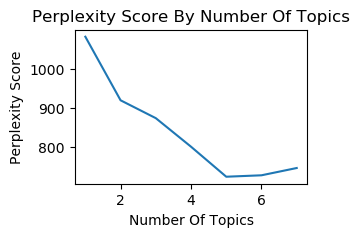

In [49]:
# perform bag of words conversion
vectorizer4, clean_vec4, feature_names_vec4 = do_bag_of_words_conversion(
    clean_sentences,
    lda_dict[mod_name]['vec_max_df'],
    lda_dict[mod_name]['vec_min_df'],
    lda_dict[mod_name]['number_features']
    )

# get perplexity and plot
perplexity4, optimal_num_topics4 = get_perplexity_and_plot(clean_vec4, 7)

In [50]:
# run the do_lda function
lda4, lda_transform4, lda_components4 = do_lda(
    clean_vec4,
    optimal_num_topics4
    )

# get nice tables
W_df4, H_df4 = get_topics(
    mod=lda4,
    vec=clean_vec4,
    names=feature_names_vec4,
    docs=raw,
    ndocs=number_docs,
    nwords=number_words
    )

In [51]:
# word topic table: top 10 words for each topic
W_df4

,Topic0,Topic1,Topic2,Topic3,Topic4
Word0,"(0.0224, blair)","(0.0115, search)","(0.034, award)","(0.0344, mobile)","(0.0139, ireland)"
Word1,"(0.017, brown)","(0.0111, share)","(0.0182, actor)","(0.0146, computer)","(0.0135, france)"
Word2,"(0.0124, howard)","(0.0093, dollar)","(0.0131, chart)","(0.0136, broadband)","(0.0128, champion)"
Word3,"(0.0094, chancellor)","(0.0092, virus)","(0.0125, oscar)","(0.0135, gadget)","(0.0128, wales)"
Word4,"(0.009, conservative)","(0.0082, software)","(0.0111, album)","(0.0135, consumer)","(0.0112, injury)"
Word5,"(0.0067, liberal)","(0.0073, microsoft)","(0.0106, actress)","(0.0134, phone)","(0.0111, coach)"
Word6,"(0.0066, parliament)","(0.007, rates)","(0.0099, movie)","(0.0119, download)","(0.011, chelsea)"
Word7,"(0.0066, democrat)","(0.0069, costs)","(0.0098, festival)","(0.01, software)","(0.0103, sport)"
Word8,"(0.0059, minister)","(0.0066, stock)","(0.0093, prize)","(0.01, camera)","(0.0083, title)"
Word9,"(0.0055, kennedy)","(0.0064, consumer)","(0.0087, producer)","(0.0093, apple)","(0.008, rugby)"


In [52]:
# document topic table: top 10 documents for each topic
H_df4

,Topic0,Topic1,Topic2,Topic3,Topic4
Doc0,"(0.9928, anti-terror plan faces first test pla...","(0.9911, security scares spark browser fix mic...","(0.9965, critics back aviator for oscars marti...","(0.9959, apple laptop is greatest gadget the...","(0.9952, nadal puts spain 2-0 up result: nadal..."
Doc1,"(0.9919, howard unveils tory asylum plans tory...","(0.9897, microsoft debuts security tools micro...","(0.9924, eastwood s baby scoops top oscars cli...","(0.995, apple laptop is greatest gadget the ...","(0.9934, britain boosted by holmes double athl..."
Doc2,"(0.9919, terror suspects face house arrest uk ...","(0.9888, car giant hit by mercedes slump a slu...","(0.9916, aviator and vera take bafta glory hol...","(0.9934, broadband set to revolutionise tv bt ...","(0.9926, wales win in rome wales secured their..."
Doc3,"(0.9911, howard denies split over id cards mic...","(0.9884, asian banks halt dollar s slide the d...","(0.9912, british stars denied major oscars bri...","(0.9934, tv s future down the phone line inter...","(0.9924, celts savour grand slam prospect the ..."
Doc4,"(0.9911, howard denies split over id cards mic...","(0.988, us trade deficit widens sharply the ga...","(0.9898, bafta to hand out movie honours movie...","(0.993, mobiles not media players yet mobile...","(0.9922, holmes back on form in birmingham dou..."
Doc5,"(0.9909, howard taunts blair over splits tony ...","(0.9875, french suitor holds lse meeting europ...","(0.989, new york rockers top talent poll new y...","(0.993, mobiles not media players yet mobile...","(0.9921, a november to remember last saturday ..."
Doc6,"(0.9908, asylum children to face returns the u...","(0.9873, domain system scam fear a system to m...","(0.989, stars shine on bafta red carpet hollyw...","(0.9929, nintendo ds aims to touch gamers the ...","(0.992, mourinho plots impressive course chels..."
Doc7,"(0.9907, no more concessions on terror charle...","(0.9871, domain system opens door to scams a s...","(0.9888, foxx and swank take actors awards jam...","(0.9929, mobile music challenges ipod age no...","(0.9919, ireland 17-12 south africa ronan o ga..."
Doc8,"(0.9906, blair defends terror law changes the ...","(0.987, microsoft sets sights on spyware windo...","(0.9886, foxx and swank win us awards jamie fo...","(0.9928, doors open at biggest gadget fair tho...","(0.9914, ireland 19-13 england ireland consign..."
Doc9,"(0.99, voters don t trust politicians eight ...","(0.9869, asia shares defy post-quake gloom ind...","(0.9884, new york rockers top talent poll new ...","(0.9928, doors open at biggest gadget fair tho...","(0.9909, henman to face saulnier test british ..."


In [53]:
# get perplexity for optimal number of topics
perplexity4 = perplexity4.loc[perplexity4['Number Of Topics'] == optimal_num_topics4, 'Perplexity Score'].values[0]
lda_dict[mod_name]['perplexity'] = perplexity4

# put the results into a dictionary
lda_dict[mod_name]['optimal_num_topics'] = optimal_num_topics4
lda_dict[mod_name]['W_df'] = W_df4
lda_dict[mod_name]['H_df'] = H_df4

### LDA Model 5 {'number_features': 1250, 'vec_max_df': 0.1, 'vec_min_df': 7}

In [54]:
mod_name = 'lda5'

# add parameters to dictionary
lda_dict[mod_name] = {
    'number_features': 1250,
    'vec_max_df': 0.1,
    'vec_min_df': 7
}

   Number Of Topics  Perplexity Score
0                 1       1090.033052
1                 2        944.608392
2                 3        860.643149
3                 4        782.771207
4                 5        745.968339
5                 6        700.945668
6                 7        730.709280
7                 8        732.874544


Optimal Number of Topics: 6


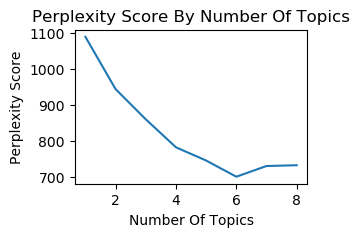

In [55]:
# perform bag of words conversion
vectorizer5, clean_vec5, feature_names_vec5 = do_bag_of_words_conversion(
    clean_sentences,
    lda_dict[mod_name]['vec_max_df'],
    lda_dict[mod_name]['vec_min_df'],
    lda_dict[mod_name]['number_features']
    )

# get perplexity and plot
perplexity5, optimal_num_topics5 = get_perplexity_and_plot(clean_vec5, 8)

In [56]:
# run the do_lda function
lda5, lda_transform5, lda_components5 = do_lda(
    clean_vec5,
    optimal_num_topics5
    )

# get nice tables
W_df5, H_df5 = get_topics(
    mod=lda5,
    vec=clean_vec5,
    names=feature_names_vec5,
    docs=raw,
    ndocs=number_docs,
    nwords=number_words
    )

In [57]:
# word topic table: top 10 words for each topic
W_df5

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5
Word0,"(0.0106, trial)","(0.0167, france)","(0.0268, blair)","(0.0311, mobile)","(0.0172, software)","(0.0369, award)"
Word1,"(0.0105, irish)","(0.015, wales)","(0.0228, brown)","(0.0147, share)","(0.0169, computer)","(0.0192, actor)"
Word2,"(0.0094, fraud)","(0.0147, champion)","(0.016, howard)","(0.0137, phone)","(0.0129, internet)","(0.0132, oscar)"
Word3,"(0.0091, scotland)","(0.0127, injury)","(0.012, chancellor)","(0.0132, dollar)","(0.0127, consumer)","(0.0128, album)"
Word4,"(0.0091, ireland)","(0.0126, chelsea)","(0.0109, conservative)","(0.0093, stock)","(0.0125, search)","(0.0124, chart)"
Word5,"(0.0077, suspect)","(0.0126, coach)","(0.0074, liberal)","(0.0093, profits)","(0.0125, microsoft)","(0.0112, movie)"
Word6,"(0.0072, lawyer)","(0.0118, sport)","(0.0074, democrat)","(0.009, airline)","(0.0111, download)","(0.0112, actress)"
Word7,"(0.0072, power)","(0.0104, ireland)","(0.0073, kennedy)","(0.0088, costs)","(0.011, broadband)","(0.0107, singer)"
Word8,"(0.0069, scottish)","(0.0092, title)","(0.0069, spending)","(0.0086, deficit)","(0.0099, gadget)","(0.0105, prize)"
Word9,"(0.0068, order)","(0.0086, rugby)","(0.0067, promise)","(0.0085, rates)","(0.0097, virus)","(0.0103, festival)"


In [58]:
# document topic table: top 10 documents for each topic
H_df5

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5
Doc0,"(0.99, worldcom director admits lying the form...","(0.9961, nadal puts spain 2-0 up result: nadal...","(0.9907, howard denies split over id cards mic...","(0.9887, asian banks halt dollar s slide the d...","(0.9927, format wars could confuse users tec...","(0.9966, critics back aviator for oscars marti..."
Doc1,"(0.9887, worldcom director ends evidence the f...","(0.9942, britain boosted by holmes double athl...","(0.9907, howard denies split over id cards mic...","(0.9886, ore costs hit global steel firms shar...","(0.9927, format wars could confuse users tec...","(0.9936, the producers scoops stage awards the..."
Doc2,"(0.9884, worldcom ex-boss launches defence law...","(0.9918, holmes back on form in birmingham dou...","(0.9895, tories attack eu asylum moves david b...","(0.9886, car giant hit by mercedes slump a slu...","(0.9926, search wars hit desktop pcs another f...","(0.9923, eastwood s baby scoops top oscars cli..."
Doc3,"(0.9873, ebbers denies worldcom fraud former w...","(0.9916, henman to face saulnier test british ...","(0.989, blair ready to call election tony blai...","(0.9875, us trade deficit widens sharply the g...","(0.9926, toxic web links help virus spread vir...","(0.9918, aviator and vera take bafta glory hol..."
Doc4,"(0.9869, woolf murder sentence rethink plans t...","(0.9911, federer joins all-time greats the las...","(0.9887, brown calls for £5.5bn aids fund gord...","(0.9871, bmw cash to fuel mini production less...","(0.9926, peer-to-peer nets here to stay peer...","(0.9907, british stars denied major oscars bri..."
Doc5,"(0.9858, no-one can define new hunt ban the n...","(0.9878, giggs handed wales leading role ryan ...","(0.9887, taxes must be trusted - kennedy publi...","(0.9836, brewers profits lose their fizz hein...","(0.9926, peer-to-peer nets here to stay peer...","(0.9899, vera drake s bafta triumph hope at th..."
Doc6,"(0.9832, guantanamo man suing government a b...","(0.9877, white prepared for battle tough-scrum...","(0.9885, debate needed on donations cap a cap...","(0.9835, mobiles rack up 20 years of use mobil...","(0.9926, concerns over windows atms cash machi...","(0.9898, bafta to hand out movie honours movie..."
Doc7,"(0.9829, ministers naive over phone-taps the...","(0.9867, sella wants michalak recall former fr...","(0.9885, debate needed on donations cap a cap...","(0.9835, mobiles rack up 20 years of use mobil...","(0.9924, rich pickings for hi-tech thieves vir...","(0.9897, foxx and swank take actors awards jam..."
Doc8,"(0.9825, borders rail link campaign rally camp...","(0.9853, france v wales (sat) stade de france ...","(0.9885, budget to set scene for election gord...","(0.9825, gm issues 2005 profits warning genera...","(0.991, security scares spark browser fix micr...","(0.9897, grammys honour soul star charles the ..."
Doc9,"(0.9721, jp morgan admits us slavery links tho...","(0.9845, campbell to extend sprint career darr...","(0.9875, will tory tax cuts lift spirits mich...","(0.9814, us trade gap ballooned in october the...","(0.9908, firefox browser takes on microsoft mi...","(0.9895, foxx and swank win us awards jamie fo..."


In [59]:
# get perplexity for optimal number of topics
perplexity5 = perplexity5.loc[perplexity5['Number Of Topics'] == optimal_num_topics5, 'Perplexity Score'].values[0]
lda_dict[mod_name]['perplexity'] = perplexity5

# put the results into a dictionary
lda_dict[mod_name]['optimal_num_topics'] = optimal_num_topics5
lda_dict[mod_name]['W_df'] = W_df5
lda_dict[mod_name]['H_df'] = H_df5

### LDA Model 6 {'number_features': 1000, 'vec_max_df': 0.02, 'vec_min_df': 12}

In [60]:
mod_name = 'lda6'

# add parameters to dictionary
lda_dict[mod_name] = {
    'number_features': 1000,
    'vec_max_df': 0.02,
    'vec_min_df': 12
}

   Number Of Topics  Perplexity Score
0                 1       1006.919845
1                 2        908.154543
2                 3        883.389881
3                 4        865.496003
4                 5        863.829785
5                 6        817.284442
6                 7        826.293538
7                 8        791.327090
8                 9        796.450217
9                10        806.293025


Optimal Number of Topics: 8


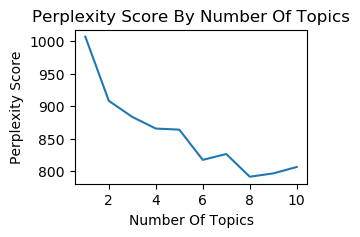

In [61]:
# perform bag of words conversion
vectorizer6, clean_vec6, feature_names_vec6 = do_bag_of_words_conversion(
    clean_sentences,
    lda_dict[mod_name]['vec_max_df'],
    lda_dict[mod_name]['vec_min_df'],
    lda_dict[mod_name]['number_features']
    )

# get perplexity and plot
perplexity6, optimal_num_topics6 = get_perplexity_and_plot(clean_vec6, 10)

In [62]:
# run the do_lda function
lda6, lda_transform6, lda_components6 = do_lda(
    clean_vec6,
    optimal_num_topics6
    )

# get nice tables
W_df6, H_df6 = get_topics(
    mod=lda6,
    vec=clean_vec6,
    names=feature_names_vec6,
    docs=raw,
    ndocs=number_docs,
    nwords=number_words
    )

In [63]:
# word topic table: top 10 words for each topic
W_df6

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7
Word0,"(0.0268, campbell)","(0.0296, google)","(0.0426, airline)","(0.0167, asylum)","(0.0179, clarke)","(0.0364, yukos)","(0.0151, worldcom)","(0.0102, poverty)"
Word1,"(0.0223, ferguson)","(0.0175, engine)","(0.034, roddick)","(0.0121, minimum)","(0.0171, straw)","(0.0206, deutsche)","(0.0138, brother)","(0.0096, korea)"
Word2,"(0.022, highdefinition)","(0.0149, infect)","(0.0291, handset)","(0.012, advice)","(0.0156, terror)","(0.0195, athens)","(0.0137, lawsuit)","(0.0095, housing)"
Word3,"(0.0198, mourinho)","(0.0148, spyware)","(0.0207, nintendo)","(0.0094, border)","(0.015, blunkett)","(0.0191, holmes)","(0.0135, wenger)","(0.0095, index)"
Word4,"(0.0188, poster)","(0.0137, laptop)","(0.0204, hewitt)","(0.009, developer)","(0.0139, arrest)","(0.0171, auction)","(0.0127, creditor)","(0.009, mortgage)"
Word5,"(0.0171, format)","(0.0132, yahoo)","(0.0185, gamers)","(0.0083, steel)","(0.013, prince)","(0.0167, medal)","(0.0121, vehicle)","(0.0087, currency)"
Word6,"(0.0159, email)","(0.0129, musician)","(0.0156, concert)","(0.0078, piracy)","(0.0129, supporting)","(0.0165, indoor)","(0.0116, recall)","(0.0085, manufacturing)"
Word7,"(0.015, henry)","(0.0127, malicious)","(0.0151, federer)","(0.0073, copyright)","(0.0126, globe)","(0.0158, athletics)","(0.0115, factory)","(0.0082, leadership)"
Word8,"(0.012, everton)","(0.0125, novel)","(0.015, sister)","(0.0073, pirate)","(0.0125, sideways)","(0.0152, insurance)","(0.0114, muslim)","(0.0079, slowdown)"
Word9,"(0.0113, blues)","(0.0124, browser)","(0.0142, republic)","(0.0072, pupil)","(0.0123, hotel)","(0.0147, welsh)","(0.0112, celebrity)","(0.0079, import)"


In [64]:
# document topic table: top 10 documents for each topic
H_df6

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7
Doc0,"(0.9757, what high-definition will do to dvds ...","(0.988, apple laptop is greatest gadget the ...","(0.9914, nadal puts spain 2-0 up result: nadal...","(0.9743, blair rejects iraq advice calls tony ...","(0.9907, critics back aviator for oscars marti...","(0.9854, britain boosted by holmes double athl...","(0.9757, worldcom director admits lying the fo...","(0.9698, s korea spending boost to economy sou..."
Doc1,"(0.9757, what high-definition will do to dvds ...","(0.9846, apple laptop is greatest gadget the...","(0.9857, henman to face saulnier test british ...","(0.9698, tories outlining policing plans local...","(0.9801, aviator and vera take bafta glory hol...","(0.9828, yukos unit fetches $9bn at auction a ...","(0.9757, worldcom ex-boss launches defence law...","(0.9698, debate needed on donations cap a cap..."
Doc2,"(0.9698, bridge could miss rest of season chel...","(0.975, security scares spark browser fix micr...","(0.9844, irish finish with home game republic ...","(0.9687, pompeii gets digital make-over the ol...","(0.975, royal couple watch nation s mood princ...","(0.9805, what now for kelly holmes last april...","(0.9742, us state acts to stop spammers us s...","(0.9698, debate needed on donations cap a cap..."
Doc3,"(0.9602, lions blow to world cup winners briti...","(0.9698, firefox browser takes on microsoft mi...","(0.9743, hewitt fights back to reach final lle...","(0.9676, peer-to-peer nets here to stay peer...","(0.9726, hollywood ready for oscars night holl...","(0.977, wales win in rome wales secured their ...","(0.9727, worldcom boss left books alone form...","(0.9687, uk interest rates held at 4.75% the b..."
Doc4,"(0.9602, lions blow to world cup stars british...","(0.9676, microsoft debuts security tools micro...","(0.9735, lifestyle governs mobile choice fas...","(0.9676, peer-to-peer nets here to stay peer...","(0.9726, bafta to hand out movie honours movie...","(0.9763, deutsche attacks yukos case german in...","(0.9687, worldcom director ends evidence the f...","(0.9676, asian banks halt dollar s slide the d..."
Doc5,"(0.9562, ferguson urges henry punishment sir a...","(0.965, virus poses as christmas e-mail securi...","(0.9735, lifestyle governs mobile choice fas...","(0.9562, bt program to beat dialler scams bt i...","(0.9708, blair defends terror law changes the ...","(0.9708, greek sprinters suspended by iaaf gre...","(0.9602, wenger rules out new keeper arsenal b...","(0.965, dollar drops on reserves concerns the ..."
Doc6,"(0.9453, mourinho defiant on chelsea form chel...","(0.965, virus poses as christmas e-mail securi...","(0.9717, camera phones are must-haves four t...","(0.9485, brown outlines third term vision gord...","(0.9676, blair rejects tory terror offer tony ...","(0.9676, verdict delay for greek sprinters gre...","(0.9602, pm apology over jailings tony blair h...","(0.9619, us retail sales surge in december us ..."
Doc7,"(0.9416, charvis set to lose fitness bid flank...","(0.965, blog picked as word of the year the t...","(0.9717, camera phones are must-haves four t...","(0.9485, brown outlines third term vision gord...","(0.9663, stars gear up for bafta ceremony film...","(0.9676, o driscoll saves irish blushes two mo...","(0.9562, boris opposes mayor apology ken livin...","(0.9602, firms pump billions into pensions emp..."
Doc8,"(0.9416, stam spices up man utd encounter ac m...","(0.9635, digital guru floats sub-$100 pc nicho...","(0.9698, nintendo handheld given euro date nin...","(0.9452, tv station refuses adoption show a tv...","(0.965, clarke to press on with id cards new h...","(0.9663, jones happy with henson heroics wales...","(0.9539, no jail for singer courtney love sing...","(0.9602, no seasonal lift for house market a s..."
Doc9,"(0.9384, gadget market to grow in 2005 the e...","(0.9635, digital guru floats sub-$100 pc nicho...","(0.9602, faultless federer has no equal roger ...","(0.9334, iraq advi

In [65]:
# get perplexity for optimal number of topics
perplexity6 = perplexity6.loc[perplexity6['Number Of Topics'] == optimal_num_topics6, 'Perplexity Score'].values[0]
lda_dict[mod_name]['perplexity'] = perplexity6

# put the results into a dictionary
lda_dict[mod_name]['optimal_num_topics'] = optimal_num_topics6
lda_dict[mod_name]['W_df'] = W_df6
lda_dict[mod_name]['H_df'] = H_df6

### Summary of LDA models

In [66]:
# to display the results
lda_t = PrettyTable()

lda_t.field_names = [
    "Model Name",
    "Optimal Number Of Topics",
    "Number Of Features",
    "Vector Max DF",
    "Vector Min DF",
    "Perplexity"
]

# loop through the models
for mod_name, mod_dict in lda_dict.items():
    # get the parameters
    num_topics = mod_dict['optimal_num_topics']
    num_features = mod_dict['number_features']
    vec_max_df = mod_dict['vec_max_df']
    vec_min_df = mod_dict['vec_min_df']
    perplexity = round(mod_dict['perplexity'], 2)

    # add a row to the table
    lda_t.add_row([
        mod_name,
        num_topics,
        num_features,
        vec_max_df,
        vec_min_df,
        perplexity
    ])

# print the table
print(lda_t)

+------------+--------------------------+--------------------+---------------+---------------+------------+
| Model Name | Optimal Number Of Topics | Number Of Features | Vector Max DF | Vector Min DF | Perplexity |
+------------+--------------------------+--------------------+---------------+---------------+------------+
|    lda1    |            7             |        1500        |      0.05     |       20      |   755.74   |
|    lda2    |            4             |        1750        |      0.05     |       12      |  1141.68   |
|    lda3    |            3             |        1500        |      0.02     |       15      |   854.0    |
|    lda4    |            5             |        1250        |      0.1      |       15      |   723.03   |
|    lda5    |            6             |        1250        |      0.1      |       7       |   700.95   |
|    lda6    |            8             |        1000        |      0.02     |       12      |   791.33   |
+------------+--------------

LDA Model 1 ----------------------------------------------------------------------------------------------------


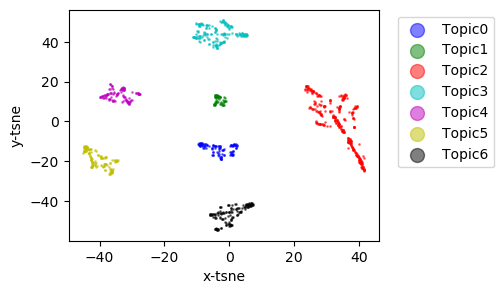

LDA Model 2 ----------------------------------------------------------------------------------------------------


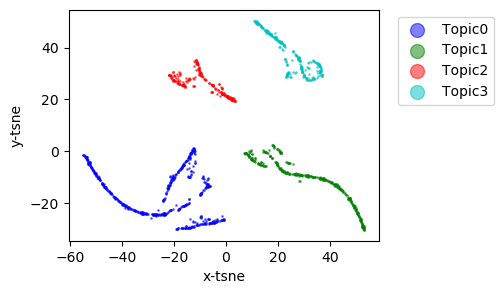

LDA Model 3 ----------------------------------------------------------------------------------------------------


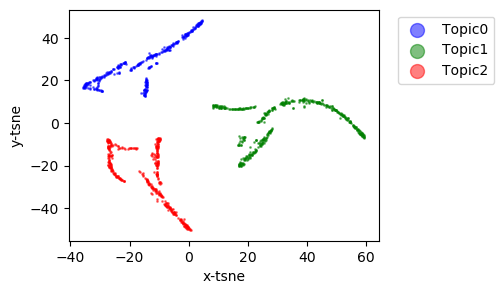

LDA Model 4 ----------------------------------------------------------------------------------------------------


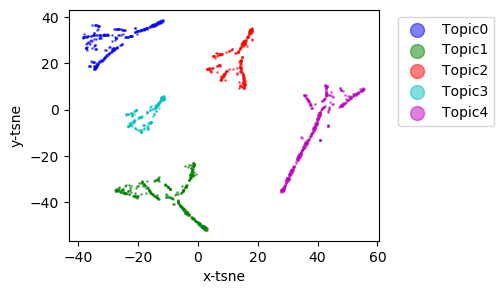

LDA Model 5 ----------------------------------------------------------------------------------------------------


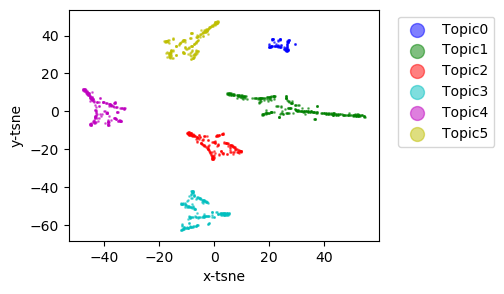

LDA Model 6 ----------------------------------------------------------------------------------------------------


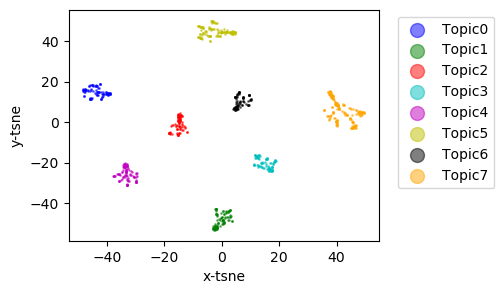

In [67]:
# plot the t-sne for all the models
print("LDA Model 1 "+"-"*100)
plt.figure(figsize=(4, 3))
plot_tsne(data=lda_transform1, threshold=0.6)
plt.show()

print("LDA Model 2 "+"-"*100)
plt.figure(figsize=(4, 3))
plot_tsne(data=lda_transform2, threshold=0.6)
plt.show()

print("LDA Model 3 "+"-"*100)
plt.figure(figsize=(4, 3))
plot_tsne(data=lda_transform3, threshold=0.6)
plt.show()

print("LDA Model 4 "+"-"*100)
plt.figure(figsize=(4, 3))
plot_tsne(data=lda_transform4, threshold=0.6)
plt.show()

print("LDA Model 5 "+"-"*100)
plt.figure(figsize=(4, 3))
plot_tsne(data=lda_transform5, threshold=0.6)
plt.show()

print("LDA Model 6 "+"-"*100)
plt.figure(figsize=(4, 3))
plot_tsne(data=lda_transform6, threshold=0.6)
plt.show()

## NMF Models

In [68]:
number_features = 1000

In [69]:
# convert to bag of words model
# use tf-idf method this time
vectorizer = sklearn.feature_extraction.text.TfidfVectorizer(
    analyzer="word",
    max_df=0.5,    # ignore words that appear in max_df% of documents
    min_df=20,    # ignore words that appear in less than min_df documents
    max_features=number_features,
    smooth_idf=False
)
tfidf = vectorizer.fit_transform(clean_sentences)

In [70]:
tfidf

<1490x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 46485 stored elements in Compressed Sparse Row format>

In [71]:
vectorizer

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=0.5, max_features=1000,
                min_df=20, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=False, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [72]:
feature_names_vect = vectorizer.get_feature_names()

In [73]:
# define and fit nmf model1

nmf_model1 = sklearn.decomposition.NMF(
    n_components=7,
    init="nndsvd",
    solver="mu",
    beta_loss="frobenius",
    random_state=0,
    alpha=0.1,
    l1_ratio=0.2
)
nmf_model1.fit(tfidf)


NMF(alpha=0.1, beta_loss='frobenius', init='nndsvd', l1_ratio=0.2, max_iter=200,
    n_components=7, random_state=0, shuffle=False, solver='mu', tol=0.0001,
    verbose=0)

In [74]:
# second nfm model
nmf_model2 = sklearn.decomposition.NMF(
    n_components=4,
    init="random",
    solver="mu",
    beta_loss="frobenius",
    random_state=42,
    alpha=0.01,
    l1_ratio=0.3
)
nmf_model2.fit(tfidf)


NMF(alpha=0.01, beta_loss='frobenius', init='random', l1_ratio=0.3,
    max_iter=200, n_components=4, random_state=42, shuffle=False, solver='mu',
    tol=0.0001, verbose=0)

In [75]:
# third nfm model
nmf_model3 = sklearn.decomposition.NMF(
    n_components=3,
    init="nndsvda",
    solver="mu",
    beta_loss="kullback-leibler",
    random_state=42,
    alpha=0.01,
    l1_ratio=0.4
)
nmf_model3.fit(tfidf)


NMF(alpha=0.01, beta_loss='kullback-leibler', init='nndsvda', l1_ratio=0.4,
    max_iter=200, n_components=3, random_state=42, shuffle=False, solver='mu',
    tol=0.0001, verbose=0)

In [76]:
# fouth nfm model
nmf_model4 = sklearn.decomposition.NMF(
    n_components=5,
    init="nndsvd",
    solver="mu",
    beta_loss="frobenius",
    random_state=42,
    alpha=0.1,
    l1_ratio=0.2
)
nmf_model4.fit(tfidf)


NMF(alpha=0.1, beta_loss='frobenius', init='nndsvd', l1_ratio=0.2, max_iter=200,
    n_components=5, random_state=42, shuffle=False, solver='mu', tol=0.0001,
    verbose=0)

In [77]:
# fifth nfm model

nmf_model5 = sklearn.decomposition.NMF(
    n_components=6,
    init="random",
    solver="cd",
    beta_loss="frobenius",
    random_state=42,
    alpha=0.1,
    l1_ratio=0.1
)
nmf_model5.fit(tfidf)

NMF(alpha=0.1, beta_loss='frobenius', init='random', l1_ratio=0.1, max_iter=200,
    n_components=6, random_state=42, shuffle=False, solver='cd', tol=0.0001,
    verbose=0)

In [78]:
# sixth nfm model

nmf_model6 = sklearn.decomposition.NMF(
    n_components=8,
    init="nndsvd",
    solver="mu",
    beta_loss="kullback-leibler",
    random_state=42,
    alpha=0.1,
    l1_ratio=0.2
)
nmf_model6.fit(tfidf)

NMF(alpha=0.1, beta_loss='kullback-leibler', init='nndsvd', l1_ratio=0.2,
    max_iter=200, n_components=8, random_state=42, shuffle=False, solver='mu',
    tol=0.0001, verbose=0)

In [79]:
all_nfm_models = [nmf_model1, nmf_model2, nmf_model3, nmf_model4, nmf_model5, nmf_model6]

### Summary of NMF models

In [80]:
all_nfm_models

[NMF(alpha=0.1, beta_loss='frobenius', init='nndsvd', l1_ratio=0.2, max_iter=200,
     n_components=7, random_state=0, shuffle=False, solver='mu', tol=0.0001,
     verbose=0),
 NMF(alpha=0.01, beta_loss='frobenius', init='random', l1_ratio=0.3,
     max_iter=200, n_components=4, random_state=42, shuffle=False, solver='mu',
     tol=0.0001, verbose=0),
 NMF(alpha=0.01, beta_loss='kullback-leibler', init='nndsvda', l1_ratio=0.4,
     max_iter=200, n_components=3, random_state=42, shuffle=False, solver='mu',
     tol=0.0001, verbose=0),
 NMF(alpha=0.1, beta_loss='frobenius', init='nndsvd', l1_ratio=0.2, max_iter=200,
     n_components=5, random_state=42, shuffle=False, solver='mu', tol=0.0001,
     verbose=0),
 NMF(alpha=0.1, beta_loss='frobenius', init='random', l1_ratio=0.1, max_iter=200,
     n_components=6, random_state=42, shuffle=False, solver='cd', tol=0.0001,
     verbose=0),
 NMF(alpha=0.1, beta_loss='kullback-leibler', init='nndsvd', l1_ratio=0.2,
     max_iter=200, n_components

In [81]:
# # nive output tables for all models
results_nmf=[]
for i, nmf_model in enumerate(all_nfm_models):
    W_df, H_df = get_topics(
        mod=nmf_model,
        vec=tfidf,
        names=feature_names_vect,
        docs=raw,
        ndocs=number_docs,
        nwords=number_words
    )
    W_df.to_csv(f'W_df_model{i}.csv', index=False)
    H_df.to_csv(f'H_df_model{i}.csv', index=False)
    results_nmf.append((W_df, H_df))

In [82]:
for i, (W_df, _) in enumerate(results_nmf, start=1):
    print(f"\n--------------> Word topic tables for model{i}:\n")
    print(W_df)
    print()


--------------> Word topic tables for model1:

                   Topic0                  Topic1              Topic2  \
Word0    (0.0592, mobile)        (0.0626, labour)   (0.0626, england)   
Word1     (0.0332, music)          (0.051, blair)     (0.0395, wales)   
Word2     (0.0228, phone)         (0.0433, brown)   (0.0338, ireland)   
Word3    (0.0177, gadget)    (0.0238, chancellor)    (0.0307, france)   
Word4    (0.0136, camera)        (0.0238, howard)    (0.0247, nation)   
Word5   (0.0129, handset)  (0.0164, conservative)     (0.0245, coach)   
Word6  (0.0127, consumer)       (0.0159, britain)     (0.0242, rugby)   
Word7  (0.0113, download)       (0.0149, kennedy)   (0.024, robinson)   
Word8   (0.0105, devices)       (0.0125, liberal)  (0.0213, scotland)   
Word9     (0.0097, radio)      (0.0119, democrat)    (0.0193, injury)   

                     Topic3             Topic4                 Topic5  \
Word0       (0.0759, award)    (0.0178, share)      (0.0446, chelsea)   
Wo

In [83]:
for i, (_, H_df) in enumerate(results_nmf, start=1):
    print(f"\n----------------->Document-topic table for model {i}:\n")
    print(H_df)


----------------->Document-topic table for model 1:

                                                 Topic0  \
Doc0  (0.3356, mobile music challenges  ipod age  no...   
Doc1  (0.3336, mobiles  not media players yet  mobil...   
Doc2  (0.3336, mobiles  not media players yet  mobil...   
Doc3  (0.3223, looks and music to drive mobiles mobi...   
Doc4  (0.3223, looks and music to drive mobiles mobi...   
Doc5  (0.3029, mobiles rack up 20 years of use mobil...   
Doc6  (0.3029, mobiles rack up 20 years of use mobil...   
Doc7  (0.3003, half of uk s mobiles  go online  mult...   
Doc8  (0.2887, friends fear  with lost mobiles peopl...   
Doc9  (0.2866, mobile gig aims to rock 3g forget abo...   

                                                 Topic1  \
Doc0  (0.3173, blair pledges unity to labour mps ton...   
Doc1  (0.3094, blair stresses prosperity goals tony ...   
Doc2  (0.3038, blair and brown criticised by mps lab...   
Doc3  (0.299, blair labour s longest-serving pm tony...   
D

In [84]:
nmf_table = PrettyTable()
nmf_table.field_names = [
    "Model Name",
    "Number Of Components",
    "Init",
    "Solver",
    "Beta Loss",
    "Random State",
    "Alpha",
    "L1 Ratio"
]

# Loop through the models
for i, nmf_model in enumerate(all_nfm_models, start=1):
    # Get the parameters
    model_name = f"Model {i}"
    n_components = nmf_model.n_components
    init = nmf_model.init
    solver = nmf_model.solver
    beta_loss = nmf_model.beta_loss
    random_state = nmf_model.random_state
    alpha = nmf_model.alpha
    l1_ratio = nmf_model.l1_ratio

    # Add a row to the table
    nmf_table.add_row([model_name, n_components, init, solver, beta_loss, random_state, alpha, l1_ratio])

# Print the table
print("\nNMF Model Details:\n")
print(nmf_table)


NMF Model Details:

+------------+----------------------+---------+--------+------------------+--------------+-------+----------+
| Model Name | Number Of Components |   Init  | Solver |    Beta Loss     | Random State | Alpha | L1 Ratio |
+------------+----------------------+---------+--------+------------------+--------------+-------+----------+
|  Model 1   |          7           |  nndsvd |   mu   |    frobenius     |      0       |  0.1  |   0.2    |
|  Model 2   |          4           |  random |   mu   |    frobenius     |      42      |  0.01 |   0.3    |
|  Model 3   |          3           | nndsvda |   mu   | kullback-leibler |      42      |  0.01 |   0.4    |
|  Model 4   |          5           |  nndsvd |   mu   |    frobenius     |      42      |  0.1  |   0.2    |
|  Model 5   |          6           |  random |   cd   |    frobenius     |      42      |  0.1  |   0.1    |
|  Model 6   |          8           |  nndsvd |   mu   | kullback-leibler |      42      |  0.1  | 

In [85]:
all_nfm_transforms = []

for i, nmf_model in enumerate(all_nfm_models, start=1):
    nmf_transform = nmf_model.transform(tfidf)
    all_nfm_transforms.append(nmf_transform)


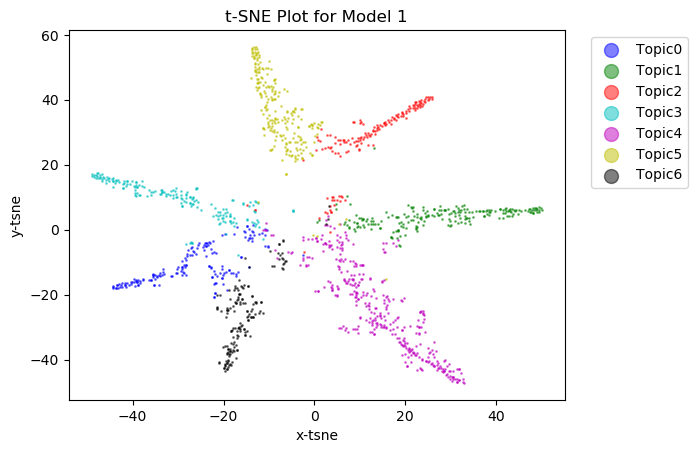

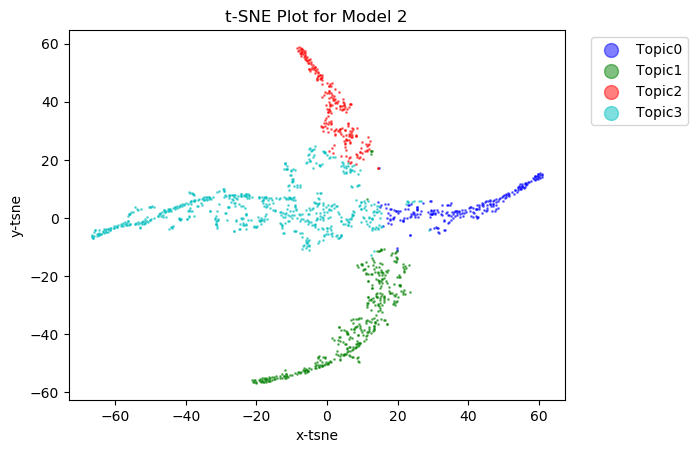

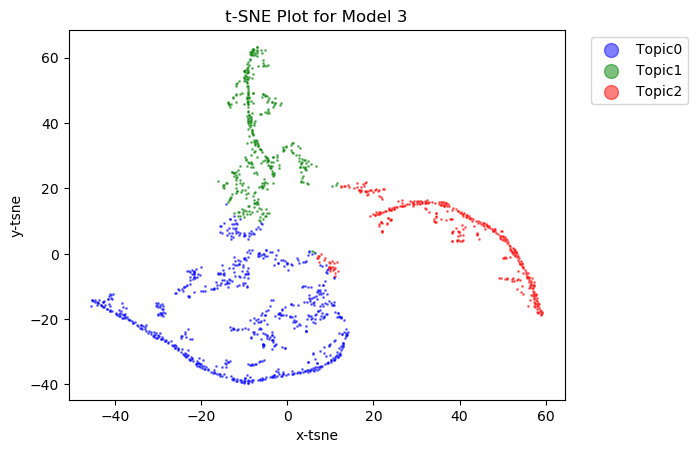

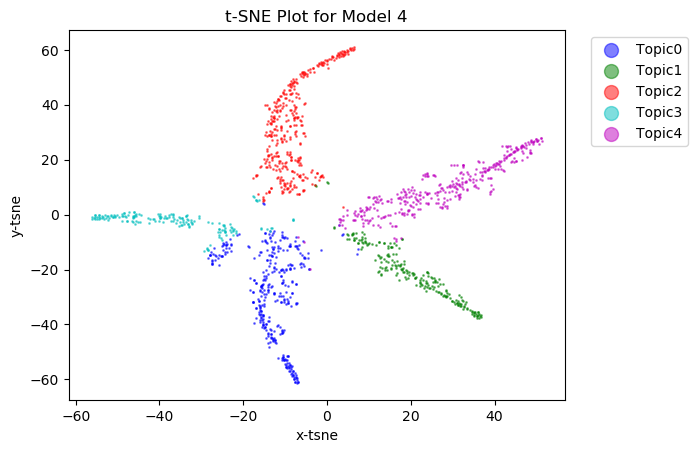

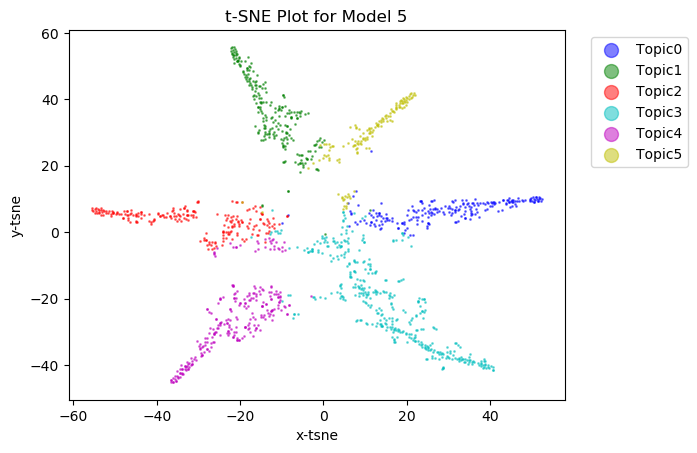

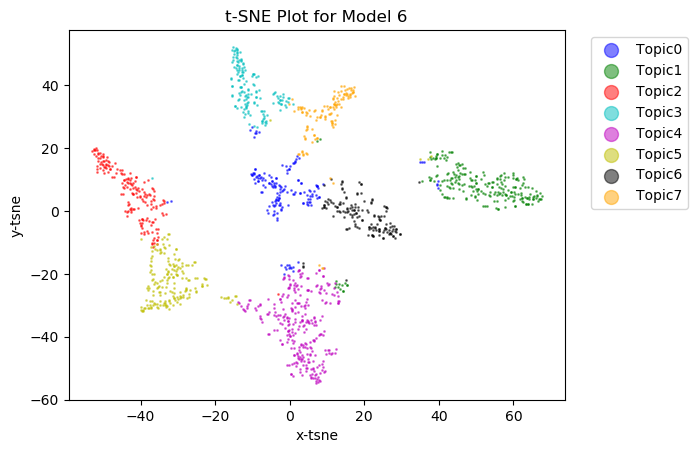

In [86]:
# plot_tsne(data=nmf_transform, threshold=0)

for i, nmf_transform in enumerate(all_nfm_transforms, start=1):
    plot_tsne(data=nmf_transform, threshold=0)
    plt.title(f"t-SNE Plot for Model {i}")
    plt.show()

In [87]:
# # calculate reconstruction error for NMF
# # lower reconstruction error indicates a better performance,
# # how well the model can reconstruct the original data from the factored matrices

for i, nmf_model in enumerate(all_nfm_models, start=1):
    reconstruction_error = nmf_model.reconstruction_err_
    print(f"Reconstruction error for nfm model {i}: {reconstruction_error}")

Reconstruction error for nfm model 1: 36.558143022957864
Reconstruction error for nfm model 2: 37.11332006130039
Reconstruction error for nfm model 3: 204.52219440397838
Reconstruction error for nfm model 4: 36.93536204386097
Reconstruction error for nfm model 5: 36.69054190969418
Reconstruction error for nfm model 6: 193.90964131803625


In [88]:
# calculate MSE
def calculate_mse(nmf_model, vectorizer):
    reconstructed_data = np.dot (nmf_model.transform(vectorizer), nmf_model.components_)
    mse = mean_squared_error(vectorizer.toarray(), reconstructed_data)

    return mse

In [89]:
all_mse_scores = []

for i, nmf_model in enumerate(all_nfm_models, start=1):
    mse_score_model = calculate_mse(nmf_model, tfidf)
    all_mse_scores.append(mse_score_model)
    print(f"MSE for Model {i}: {mse_score_model}")

MSE for Model 1: 0.000896108990616336
MSE for Model 2: 0.0009244263849126298
MSE for Model 3: 0.0009476839592100634
MSE for Model 4: 0.000914982121437358
MSE for Model 5: 0.0009034872329086749
MSE for Model 6: 0.0009069650086367609


# **Discussion:**

## **the Best LDA model**

**Discussion**

Let's first read the word topic table and the document topic table of all the LDA models and understand the abstract topics.

**LDA Model 1**: Topic0 and Topic1 are overlapping topics; they are movies and music, which are about entertainment.

**LDA Model 2**: Topic0 is a mix of local news, international news and sports.

**LDA Model 3**: Topic0 does not have a central theme in the topic. Topic1 is a mix of sports and entertainment. Topic2 is a mix of politics and international news.

**LDA Model 4**: The topics are very clear. Topic0: news; Topic1: economy; Topic2: entertainment; Topic3: technology; and Topic4: sports.

**LDA Model 5**: Topic0 and Topic2 are duplicated theme; they both centralized around politics.

**LDA Model 6**: Topic0, Topic1, Topic2 are mixed topics on sports and technology.

Looking at the T-SNE plots, LDA Model 2, LDA Model 3, LDA Model 4 and LDA Model 5 all show clear clusters with good separation between the topics. Yet the topics are spread out which means the topics appear across the corpus.

After checking the word topic table and the document topic table of all the LDA models, as well as their T-SNE plots, **LDA Model 4** is the best. It successfully separates the news into a clear category of 5 different topics.

In [90]:
# set up the best LDa model
best_lda = lda4
best_lda_mod_name = 'lda4'

best_lda_vec = vectorizer4
best_lda_clean_vec = clean_vec4

In [91]:
# print the perplexity of the best LDA model
print("Perplexity of the best LDA model: {}".format(lda_dict[best_lda_mod_name]['perplexity']))

Perplexity of the best LDA model: 723.0339512765823


In [92]:
# display the word-topic table of the best LDA model
lda_dict[best_lda_mod_name]['W_df']

,Topic0,Topic1,Topic2,Topic3,Topic4
Word0,"(0.0224, blair)","(0.0115, search)","(0.034, award)","(0.0344, mobile)","(0.0139, ireland)"
Word1,"(0.017, brown)","(0.0111, share)","(0.0182, actor)","(0.0146, computer)","(0.0135, france)"
Word2,"(0.0124, howard)","(0.0093, dollar)","(0.0131, chart)","(0.0136, broadband)","(0.0128, champion)"
Word3,"(0.0094, chancellor)","(0.0092, virus)","(0.0125, oscar)","(0.0135, gadget)","(0.0128, wales)"
Word4,"(0.009, conservative)","(0.0082, software)","(0.0111, album)","(0.0135, consumer)","(0.0112, injury)"
Word5,"(0.0067, liberal)","(0.0073, microsoft)","(0.0106, actress)","(0.0134, phone)","(0.0111, coach)"
Word6,"(0.0066, parliament)","(0.007, rates)","(0.0099, movie)","(0.0119, download)","(0.011, chelsea)"
Word7,"(0.0066, democrat)","(0.0069, costs)","(0.0098, festival)","(0.01, software)","(0.0103, sport)"
Word8,"(0.0059, minister)","(0.0066, stock)","(0.0093, prize)","(0.01, camera)","(0.0083, title)"
Word9,"(0.0055, kennedy)","(0.0064, consumer)","(0.0087, producer)","(0.0093, apple)","(0.008, rugby)"


In [93]:
# display the document-topic table of the best LDA model
lda_dict[best_lda_mod_name]['H_df']

,Topic0,Topic1,Topic2,Topic3,Topic4
Doc0,"(0.9928, anti-terror plan faces first test pla...","(0.9911, security scares spark browser fix mic...","(0.9965, critics back aviator for oscars marti...","(0.9959, apple laptop is greatest gadget the...","(0.9952, nadal puts spain 2-0 up result: nadal..."
Doc1,"(0.9919, howard unveils tory asylum plans tory...","(0.9897, microsoft debuts security tools micro...","(0.9924, eastwood s baby scoops top oscars cli...","(0.995, apple laptop is greatest gadget the ...","(0.9934, britain boosted by holmes double athl..."
Doc2,"(0.9919, terror suspects face house arrest uk ...","(0.9888, car giant hit by mercedes slump a slu...","(0.9916, aviator and vera take bafta glory hol...","(0.9934, broadband set to revolutionise tv bt ...","(0.9926, wales win in rome wales secured their..."
Doc3,"(0.9911, howard denies split over id cards mic...","(0.9884, asian banks halt dollar s slide the d...","(0.9912, british stars denied major oscars bri...","(0.9934, tv s future down the phone line inter...","(0.9924, celts savour grand slam prospect the ..."
Doc4,"(0.9911, howard denies split over id cards mic...","(0.988, us trade deficit widens sharply the ga...","(0.9898, bafta to hand out movie honours movie...","(0.993, mobiles not media players yet mobile...","(0.9922, holmes back on form in birmingham dou..."
Doc5,"(0.9909, howard taunts blair over splits tony ...","(0.9875, french suitor holds lse meeting europ...","(0.989, new york rockers top talent poll new y...","(0.993, mobiles not media players yet mobile...","(0.9921, a november to remember last saturday ..."
Doc6,"(0.9908, asylum children to face returns the u...","(0.9873, domain system scam fear a system to m...","(0.989, stars shine on bafta red carpet hollyw...","(0.9929, nintendo ds aims to touch gamers the ...","(0.992, mourinho plots impressive course chels..."
Doc7,"(0.9907, no more concessions on terror charle...","(0.9871, domain system opens door to scams a s...","(0.9888, foxx and swank take actors awards jam...","(0.9929, mobile music challenges ipod age no...","(0.9919, ireland 17-12 south africa ronan o ga..."
Doc8,"(0.9906, blair defends terror law changes the ...","(0.987, microsoft sets sights on spyware windo...","(0.9886, foxx and swank win us awards jamie fo...","(0.9928, doors open at biggest gadget fair tho...","(0.9914, ireland 19-13 england ireland consign..."
Doc9,"(0.99, voters don t trust politicians eight ...","(0.9869, asia shares defy post-quake gloom ind...","(0.9884, new york rockers top talent poll new ...","(0.9928, doors open at biggest gadget fair tho...","(0.9909, henman to face saulnier test british ..."


In [94]:
# iteractive plot with pca biplot and histogram

# use the appropriate code depending on the environment
lda_plot = pyLDAvis.sklearn.prepare(best_lda, best_lda_clean_vec, best_lda_vec, R=10)
#lda_plot = pyLDAvis.lda_model.prepare(best_lda, best_lda_clean_vec, best_lda_vec, R=10)

pyLDAvis.display(lda_plot)

**Topics Found in pyLDAvis**
* Topic 1: politics
* Topic 2: business
* Topic 3: sports
* Topic 4: technology
* Topic 5: entertainment

## **the Best NMF model**

Our best model nmf_model5, has 1000 features using the TF-IDF method and has 6 components.

The model's reconstruction error is 36.69, which means it has a good capacity to reconstruct the original data from factored matrices. The MSE nmf_model5 is 0.000903, a basic number that means precision in the approximation of the original data.
We see no overlapping when we use word cloud, the topics are clear, and well-separated.
The model nmf_model5 has a low reconstruction error and MSE, Model 5 effectively captures and represents the underlying structure of the data.
Clear separation with topics covering mobile, music, software, and political figures.
Distinct and well-defined topics.

**NMF Model 1**
Good separation per topic.
Topics include mobile, music, awards, and political figures.
Model 1 demonstrates a relatively low reconstruction error and MSE, indicating effective data reconstruction.

**NMF Model 2**
Good separation per topic
Topics cover political figures, sports, and awards.
Despite a slightly higher reconstruction error, Model 2 maintains a moderate MSE. The data reconstruction is generally accurate.

**NMF Model 3**
High MSE and reconstruction errors suggest less effective data reconstruction.
Some overlap and less distinct separation between topics.

**NMF Model 4**
Has the lowest MSE
Good separation per topic

**NMF Model 6**
High MSE and reconstruction errors suggest less effective data reconstruction.
Slight overlap, but the topics are well-differentiated.

In [97]:
def plot_word_clouds_for_model(W_df, model_index):
    for topic_idx in range(W_df.shape[1]):
        word_weights = {word: weight for (weight, word) in W_df[f'Topic{topic_idx}']}
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_weights)
        plt.figure(figsize=(4, 4))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f'Word Cloud for Topic {topic_idx + 1} (Model {model_index + 1})')
        plt.show()

In [98]:
# set up the best NMF model
best_nmf = nmf_model1
best_nmf_mod_name = 'nmf5'

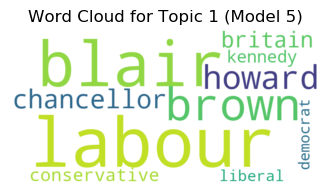

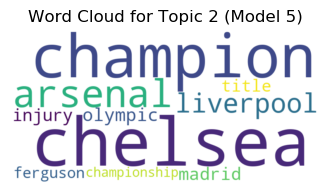

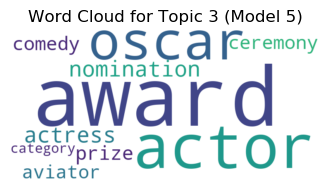

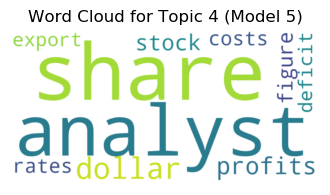

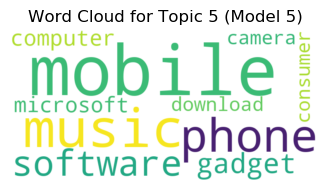

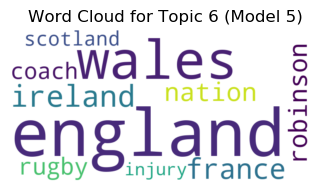

In [99]:
model_index = 4  # index starts with 0
W_df_model5, _ = results_nmf[model_index]

plot_word_clouds_for_model(W_df_model5, model_index)

In [100]:
# display the word-topic table of the best NMF model
best_nmf_index = 4
best_nmf_W_df, _ = results_nmf[best_nmf_index]
print(f"\n--------------> Word topic tables for the best NMF model:\n")
print(best_nmf_W_df)


--------------> Word topic tables for the best NMF model:

                       Topic0                  Topic1                Topic2  \
Word0        (0.0482, labour)       (0.0345, chelsea)       (0.0582, award)   
Word1         (0.0396, blair)      (0.0274, champion)        (0.029, actor)   
Word2         (0.0333, brown)       (0.0232, arsenal)       (0.0272, oscar)   
Word3        (0.0188, howard)     (0.0159, liverpool)  (0.0192, nomination)   
Word4    (0.0183, chancellor)       (0.0144, olympic)     (0.0191, actress)   
Word5       (0.0129, britain)        (0.0135, madrid)       (0.0147, prize)   
Word6  (0.0129, conservative)        (0.0129, injury)     (0.014, ceremony)   
Word7       (0.0117, kennedy)         (0.0122, title)      (0.0139, comedy)   
Word8       (0.0098, liberal)      (0.0111, ferguson)     (0.0134, aviator)   
Word9      (0.0094, democrat)  (0.0106, championship)    (0.0124, category)   

                  Topic3              Topic4              Topic5  
Wor

In [101]:
# display the document-topic table of the best NMF model
_, best_nmf_H_df = results_nmf[best_nmf_index]
print(f"\n-----------------> Document-topic table for the best NMF model:\n")
print(best_nmf_H_df)



-----------------> Document-topic table for the best NMF model:

                                                 Topic0  \
Doc0  (0.3272, blair pledges unity to labour mps ton...   
Doc1  (0.3171, blair stresses prosperity goals tony ...   
Doc2  (0.3134, blair and brown criticised by mps lab...   
Doc3  (0.3082, blair labour s longest-serving pm ton...   
Doc4  (0.3055, labour mp praises tory campaign the c...   
Doc5  (0.2987, brown outlines third term vision gord...   
Doc6  (0.2987, brown outlines third term vision gord...   
Doc7  (0.293, brown  proud of economy record  gordon...   
Doc8  (0.2918, howard taunts blair over splits tony ...   
Doc9  (0.2904, labour seeks to quell feud talk labou...   

                                                 Topic1  \
Doc0  (0.2574, mourinho plots impressive course chel...   
Doc1  (0.2541, desailly backs blues revenge trip mar...   
Doc2  (0.2495, mourinho defiant on chelsea form chel...   
Doc3  (0.2384, gallas sees two-horse race chelse

# **Conclusion:**

Overall, the best model is LDA model 4, with features 1250 words and parameters disregarding words that appear in 10% of the records and those that appear in less than 15 records.

In comparison to the optimal NMF model, it was observed that the best NMF model identifies six topics, with topics 1 and 5 exhibiting an overlap in the sports category. This indicates an issue of over-cooked topics.

Quantitatively, LDA Model 4 achieved the second-lowest perplexity score at 723, surpassing the lowest-scoring yet overly specific Model 5 (700).

Qualitatively, LDA model 4's pyLDAvis bubbles have a reasonable size which indicates that each topic is relatively balanced across the entire dataset and distinct circles which reflect the distinct topics. The T-SNE plot demonstrates that there are 5 distinct clusters.

The best model accurately classifies news articles into 5 categories which align with the 5 topics in the original dataset. This model can be a valuable tool for personalized news feeds, targeted advertising, and trend analysis. Stakeholders can leverage this model to gain insights into new trends, optimize decision-making and enhance their user experiences in applications such as personalized news feeds.